# Ezekiel Elliott Performance With The Dallas Cowboys
##### A Football Data Analysis by Konner Devoto

## Introduction

Football season is right around the corner and Fall is in the air - well, almost anyways. That means it is time to combine two of my favorite things: Data Visualization & Football. I have been inspired by the soon to be published O'Reilly book: Football Analytics with Python & R by Eric A. Eager, Richard A. Erickson, and will be playing around to answer questions I have about my favorite sport and those who play it. 

If you enjoy this notebook, keep an eye out for more posts throughout the season (if I feel like it - this is for fun!). Also, I love talking about these things and learning from others. If you have recommendations on how I can improve these types of notebooks please reach out to me!

## Cowboys Have Moved on From Zeke

If you have followed the Dallas Cowboys in recent years, you will remember that despite some off the field turbulance, Ezekiel Elliott played a key role for the Dallas Cowboys offense since being drafted 4th overall in the 2016 draft. Zeke has been synonomous with Dallas football and as a fan I have enjoyed watching him punish defenses with bruising runs and jumping into the Salvation Army bucket after scoring touchdowns. 

However, most Cowboys fans will probably tell you that there was a slow decline in Zeke's production since his start on the team. So much so, that many fans were relieved to see that the team decided to stop "Feeding Zeke" and released him prior to the 2023 season; making Tony Pollard the new premier Running Back of the franchise. 

In this notebook, I wanted to try to understand if the fan sentiment was actually true answering the following questions: 
- "Is Zeke really not the back he used to be?"
- "Is he still a valuable back for his new team, the New England Patriots?"

## Evaluating Zeke's Performance

#### Import Necessary Packages

In [1]:
import pandas as pd
import numpy as np
import nfl_data_py as nfl
import seaborn as sns
import matplotlib.pyplot as plt
import types
import tensorflow as tf
import scipy.stats as stats
from tabulate import tabulate

#List versions of packages at time of running notebook:
print('\n'.join(f'{m.__name__}=={m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))

pandas==2.0.3
numpy==1.24.3
seaborn==0.12.2
tensorflow==2.13.0


#### Obtain Dataset

Zeke was drafted in 2016 and played for the Dallas Cowboys through the end of the 2022 season. Let's snag those seasons from the NFL Dataset.

In [2]:
seasons = range(2016, 2022 + 1)
pbp_py = nfl.import_pbp_data(seasons)

2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
Downcasting floats.


In [3]:
#Limit down to only the plays where Dallas is on offense.
pbp_py_dallas = \
    pbp_py\
    .query("posteam == 'DAL'")\
    .reset_index()

After doing quite a bit of analysis on the available data, I have come up with a list of key fields that I believe would be important when measuring offensive performance. We will not use all of these fields in this notebook, but I felt it made sense to bring them all in, in case I got curious.

If you are new to football and do not understand some of these terms, I have provided a brief description of every term at the end of this notebook. 

In [5]:
key_fields=['play_id','season_type', 'game_id','week','posteam','down', 'ydstogo','play_type',
            'pass_length','pass_location','air_yards',
            'yards_after_catch','run_location','run_gap','td_player_name','td_player_id',
            'epa','first_down_rush','third_down_converted','third_down_failed','fourth_down_converted',
            'fourth_down_failed','fumble_forced','fumble_not_forced','tackled_for_loss','rush_touchdown',
            'pass_touchdown','fumble','rushing_yards','receiving_yards','season','play_type_nfl',
            'rusher','receiver','offense_formation','offense_personnel','defenders_in_box','defense_personnel']
pbp_reduced = pbp_py_dallas[key_fields]

Now that we have greatly reduced the number of fields in the dataset, let's limit down to only the plays where Zeke rushed the ball. 
It should be noted that a Running Back's value to a team is more than just their rushing performance - pass blocking and pass catching are essential parts of their game. However, today we are only going to take a look at Zeke's impact running the ball.

Also, since *sigh* the Cowboys do not make the post season on a consistent basis, I am looking only at Regular season statistics to keep the evaluation consistent from year to year. 

In [6]:
#Limit down to only the plays where Dallas ran a running play on offense
zeke_runs = \
    pbp_reduced\
    .query("play_type_nfl == 'RUSH'& rusher=='E.Elliott' & season_type=='REG'")\
    .reset_index()
zeke_runs.head()

,index,play_id,season_type,game_id,week,posteam,down,ydstogo,play_type,pass_length,...,rushing_yards,receiving_yards,season,play_type_nfl,rusher,receiver,offense_formation,offense_personnel,defenders_in_box,defense_personnel
0,1,60.0,REG,2016_01_NYG_DAL,1,DAL,1.0,10.0,run,None,...,1.0,NaN,2016,RUSH,E.Elliott,None,SINGLEBACK,"1 RB, 2 TE, 2 WR",6.0,"4 DL, 3 LB, 4 DB"
1,3,110.0,REG,2016_01_NYG_DAL,1,DAL,3.0,1.0,run,None,...,3.0,NaN,2016,RUSH,E.Elliott,None,SINGLEBACK,"1 RB, 3 TE, 1 WR",7.0,"4 DL, 3 LB, 4 DB"
2,5,163.0,REG,2016_01_NYG_DAL,1,DAL,1.0,10.0,run,None,...,5.0,NaN,2016,RUSH,E.Elliott,None,SINGLEBACK,"1 RB, 1 TE, 3 WR",7.0,"4 DL, 2 LB, 5 DB"
3,6,184.0,REG,2016_01_NYG_DAL,1,DAL,2.0,5.0,run,None,...,1.0,NaN,2016,RUSH,E.Elliott,None,SHOTGUN,"2 RB, 1 TE, 2 WR",6.0,"4 DL, 3 LB, 4 DB"
4,9,253.0,REG,2016_01_NYG_DAL,1,DAL,2.0,1.0,run,None,...,5.0,NaN,2016,RUSH,E.Elliott,None,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"4 DL, 2 LB, 5 DB"


#### Did the Dallas Cowboys 'Feed Zeke' Enough?

As a fan, it felt like Zeke had less of an impact on games as his career with the Dallas Cowboys continued. I wanted to see if this was supported by data. So the first thing I looked at was how many rushing attempts Zeke had per season. 

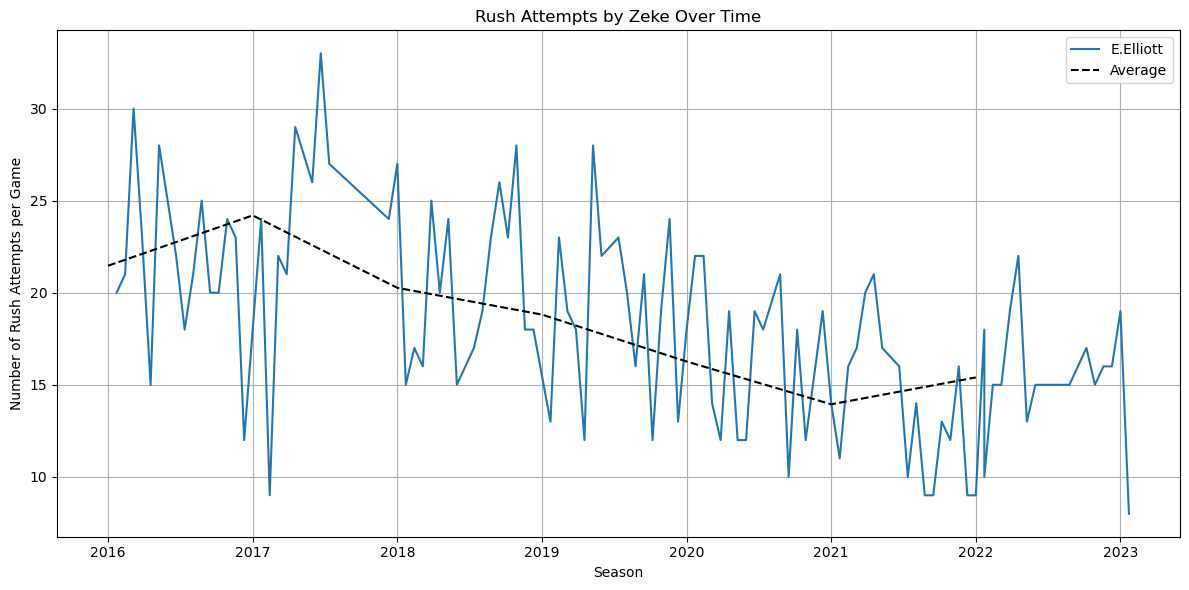

In [9]:
rush_counts = zeke_runs.groupby(['rusher', 'season', 'week'])['play_id'].count().reset_index()
rush_counts = rush_counts.sort_values(by=['season', 'week'])
average_play_count_by_season = rush_counts.groupby('season')['play_id'].mean().reset_index()

# Plot the data
plt.figure(figsize=(12, 6))

for rusher in rush_counts['rusher'].unique():
    data = rush_counts[rush_counts['rusher'] == rusher]
    plt.plot(data['season'] + (data['week'] / 17), data['play_id'], label=rusher)

# Plot the average line
plt.plot(average_play_count_by_season['season'], average_play_count_by_season['play_id'], 
         label='Average', linestyle='--', color='black')

# Customize the plot
plt.xlabel('Season')
plt.ylabel('Number of Rush Attempts per Game')
plt.title('Rush Attempts by Zeke Over Time')
plt.legend(loc='best', bbox_to_anchor=(1, 1))

# Show the plot
plt.grid(True)
plt.tight_layout()
plt.show()

Wow, I gotta be honest here. I did not expect such a clear decline in utilization for Zeke. While there may be a number of contributing factors to this (more success passing, "running back by committee", trying to keep Zeke healthy, etc.) one thing is clear - the Cowboys used Zeke less as a running back as time went on. 

At this point, I see that Zeke was getting less running plays called for him... but, was he still taking advantage of the opportunites he did get? A general measure of success when running the ball is yards gained (there are some caveats to this - like on 4th & 1, you are really only trying to get 1 yard and don't care if you get 10), so lets take a simple look at Zeke's average yards per carry over the same time period. 

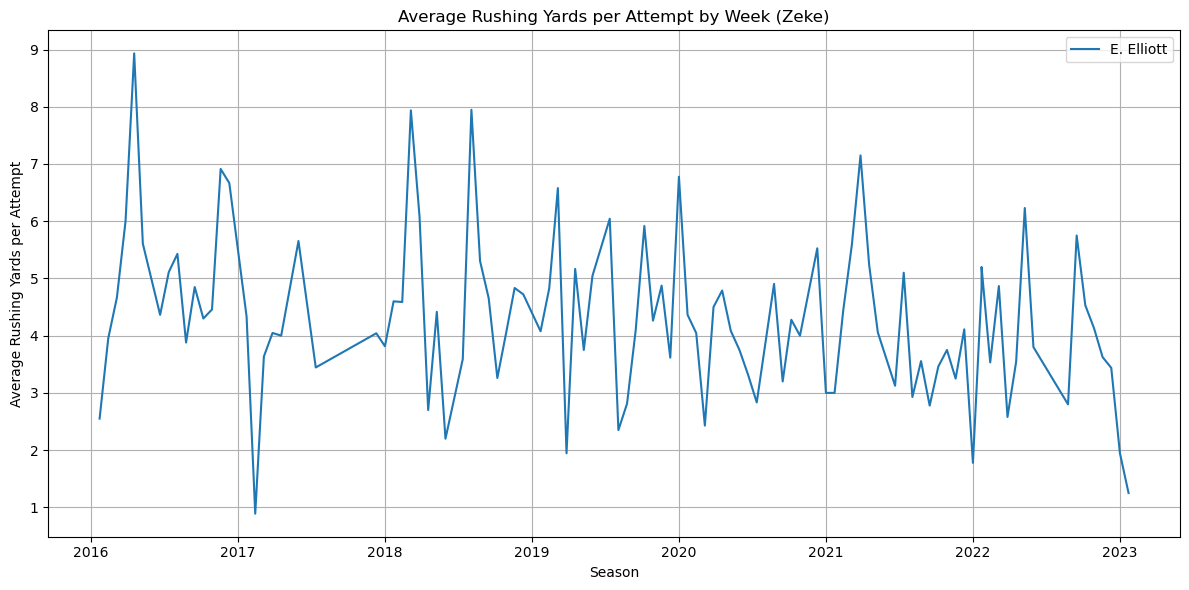

In [12]:
elliott_weekly_stats = zeke_runs.groupby(['season', 'week']).agg(
    total_rushing_yards=('rushing_yards', 'sum'),
    total__rush_attempts=('play_id', 'count')
).reset_index()

elliott_weekly_stats['avg_rushing_yards_per_attempt'] = elliott_weekly_stats['total_rushing_yards'] / elliott_weekly_stats['total__rush_attempts']

# Plot the data
plt.figure(figsize=(12, 6))

plt.plot(elliott_weekly_stats['season'] + (elliott_weekly_stats['week'] / 17), elliott_weekly_stats['avg_rushing_yards_per_attempt'], label='E. Elliott')

# Customize the plot
plt.xlabel('Season')
plt.ylabel('Average Rushing Yards per Attempt')
plt.title('Average Rushing Yards per Attempt by Week (Zeke)')
plt.legend(loc='best', bbox_to_anchor=(1, 1))

# Show the plot
plt.grid(True)
plt.tight_layout()
plt.show()

Interesting, it seems that Zeke's average yards per rushing attempt metric was relatively consistent throughout his tenure with Dallas. Based on this chart, it would seem that Zeke was consistent with the opportunities he was given. At the very least, you could make the argument that his decline in yards was driven by a reduced number of attempts. 

Let's try to visualize this. 

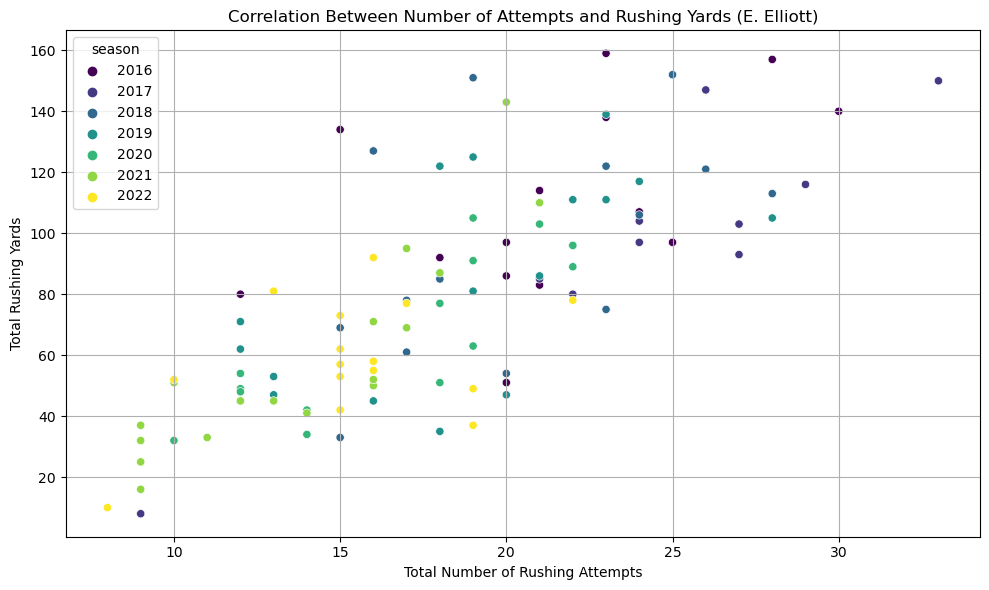

In [14]:
# Create a scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='total__rush_attempts', y='total_rushing_yards', hue='season', data=elliott_weekly_stats, palette='viridis')

# Customize the plot
plt.title('Correlation Between Number of Attempts and Rushing Yards (E. Elliott)')
plt.xlabel('Total Number of Rushing Attempts')
plt.ylabel('Total Rushing Yards')
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

Personally, I really like this chart. I think it shows a strong correlation between the number of rushing attempts and the number of total yards. It also highlights that Zeke never had more than 25 touches in a game after 2020... The Tony Pollard Effect?

Key Takeaways:
- Zeke's production (at least in terms of rushing yards) clearly declined over time. 
- While there are more factors to consider, I think this analysis supports the fact that Zeke is still a viable back for a team and he can be counted on to make good use of his opportunities when given the chance. 

### A Third Down Back?

Now that Zeke is on the Patriots, I have heard many people say that they view him as a "Third Down Back" or "Goal Line Back", meaning that Zeke will get the ball in short yardage situations and they will use him to try to get a new set of downs. 

I wanted to take a look at Zeke's historical performance with the Cowboys to see if he was still effective in this role. 

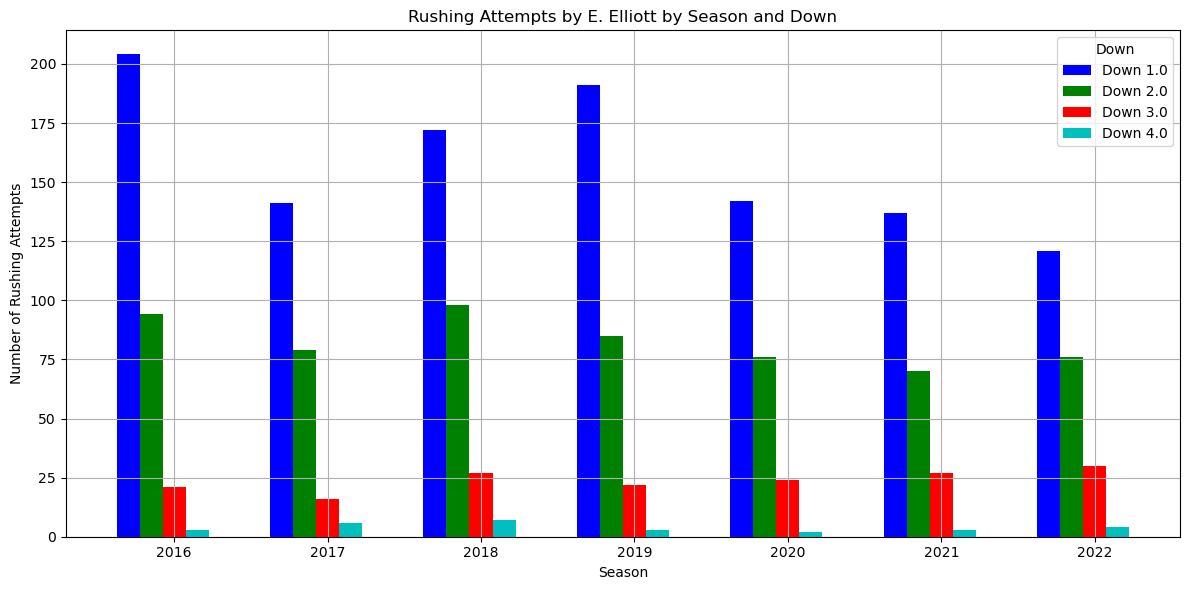

In [15]:
#Create a new dataframe looking at Zeke rushing attempts by down. 
#Did they reduce they turn him into a 3rd down back as he aged?

elliott_rushing_attempts_by_season_down = zeke_runs.groupby(['season', 'down'])['play_id'].count().reset_index()

# Pivot the data for easier plotting
pivot_table = elliott_rushing_attempts_by_season_down.pivot(index='season', columns='down', values='play_id').fillna(0)

# Define colors for bars
colors = ['b', 'g', 'r', 'c', 'm']

# Create the grouped bar chart
plt.figure(figsize=(12, 6))
width = 0.15
x = np.arange(len(pivot_table.index))

for i, down in enumerate(pivot_table.columns):
    plt.bar(x + (i * width), pivot_table[down], width=width, label=f'Down {down}', color=colors[i])

# Customize the plot
plt.xlabel('Season')
plt.ylabel('Number of Rushing Attempts')
plt.title('Rushing Attempts by E. Elliott by Season and Down')
plt.xticks(x + (width * 2), pivot_table.index)
plt.legend(title='Down')

# Show the plot
plt.grid(True)
plt.tight_layout()
plt.show()

While the Cowboys certainly utilized Zeke less based on the section above, the chart above shows that they actually increased the number of carries that he got in Third Down situations. Interesting. I wonder how he performed on third downs? 

To answer this question, I don't care as much about the yards he gained, but rather I care if he gained *enough* yards to get a new set of downs. 

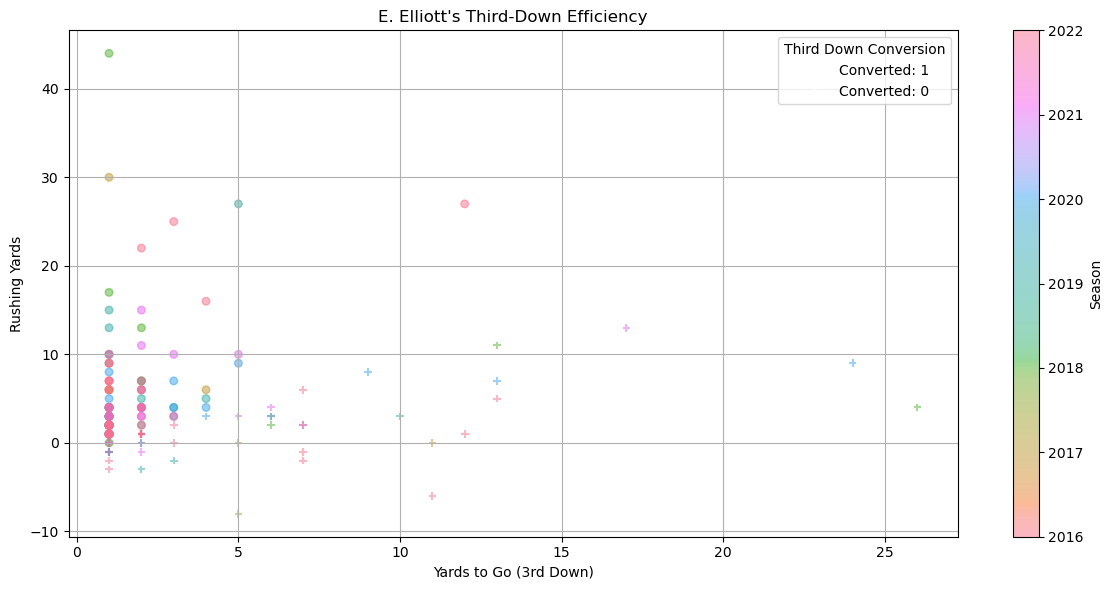

In [16]:
elliott_third_down_rushing_plays = pbp_reduced[(pbp_reduced['rusher'] == 'E.Elliott') & (pbp_reduced['play_type_nfl'] == 'RUSH') & (pbp_reduced['down'] == 3)]

# Define color palette for dot colors based on 'season'
palette = sns.color_palette("husl", as_cmap=True)

# Define marker symbols based on 'third_down_converted'
marker_symbols = {1: 'o', 0: '+'}

# Create the scatter plot
plt.figure(figsize=(12, 6))
ax = plt.gca()

# Iterate through unique values of 'third_down_converted'
for converted_value, marker in marker_symbols.items():
    subset = elliott_third_down_rushing_plays[elliott_third_down_rushing_plays['third_down_converted'] == converted_value]
    
    # Create a scatter plot for each 'third_down_converted' value
    ax.scatter(
        x=subset['ydstogo'],
        y=subset['rushing_yards'],
        c=subset['season'],
        cmap=palette,
        marker=marker,
        label=f'Converted: {converted_value}',
        alpha=0.5,  # Adjust the alpha value to control transparency
        s=30,       # Adjust the marker size for better visibility
    )

# Customize the plot
ax.set_title("E. Elliott's Third-Down Efficiency")
ax.set_xlabel('Yards to Go (3rd Down)')
ax.set_ylabel('Rushing Yards')
ax.grid(True)

# Add a colorbar legend for seasons
cbar = plt.colorbar(ax.collections[0], label='Season')

# Add legend for marker symbols
legend_markers = [plt.Line2D([0], [0], marker=marker, color='w', markersize=15, label=f'Converted: {converted}') for converted, marker in marker_symbols.items()]
ax.legend(handles=legend_markers, title='Third Down Conversion', loc='best')

# Show the plot
plt.tight_layout()
plt.show()

This chart has a 'o' when Zeke successfully picked up a third down and a '+' when he was stopped short of the line to gain. Interesting. I think this chart shows that he was pretty successful as a short yardage back in his career with the Cowboys, but it is a little hard to evaluate his past performance vs recent years. 

Let's put together a quick summary table and see how the figures look by season.

In [17]:
# Calculate statistics by season
seasonal_summary = elliott_third_down_rushing_plays.groupby('season').agg({
    'ydstogo': 'mean',
    'rushing_yards': 'mean',
    'defenders_in_box': 'mean',
    'third_down_converted': lambda x: (x.sum() / len(x)) * 100  # Calculate % of third-down conversions
}).reset_index()

# Format 'season' as integers (remove decimals)
seasonal_summary['season'] = seasonal_summary['season'].astype(int)

# Rename columns for clarity
seasonal_summary.columns = ['Season', 'Avg Yds to Go', 'Avg Rushing Yards', 'Avg Defenders In Box', '% Converted on 3rd Down']

# Round numerical values
seasonal_summary = seasonal_summary.round({'Avg Yds to Go': 2, 'Avg Rushing Yards': 2, 'Avg Defenders In Box':1, '% Converted on 3rd Down': 2})

# Add a title to the table
table_title = "E. Elliott's Third-Down Efficiency by Season"

# Convert the DataFrame to a table format
table = tabulate(seasonal_summary, headers='keys', tablefmt='pretty', showindex=False)

# Display the presentation-worthy table with title
print(table_title)
print(table)

E. Elliott's Third-Down Efficiency by Season
+--------+---------------+-------------------+----------------------+-------------------------+
| Season | Avg Yds to Go | Avg Rushing Yards | Avg Defenders In Box | % Converted on 3rd Down |
+--------+---------------+-------------------+----------------------+-------------------------+
| 2016.0 |     2.33      |       2.33        |         7.4          |          52.38          |
| 2017.0 |     3.06      |       3.94        |         7.6          |          56.25          |
| 2018.0 |     2.66      |       4.93        |         7.2          |          68.97          |
| 2019.0 |     2.18      |        4.5        |         7.0          |          72.73          |
| 2020.0 |     3.62      |       3.67        |         6.8          |          62.5           |
| 2021.0 |     2.62      |       4.14        |         7.0          |          68.97          |
| 2022.0 |     2.68      |       4.88        |         7.2          |          67.65       

I think the table above shows that Zeke is definitely still an effective short yardage back in the NFL. I think the Patriots will have success using him in this type of role. 

Note that I have also included a metric here for the number of defenders in the box. This an important metric when evaluating success of running backs because it shows how the defense is responding to try to stop them. Zeke has shown that he can consistently be effective against these run stopping formations. 

Key Takeaway:
- Patriots, If you need less than 3 yards on third down - FEED ZEKE - historically over 2/3 of the time he is going to move the chains!

### Conclusion

Overall, many Cowboys fans were right. Zeke did produce less for the team in recent years compared to when he was first drafted (from a yardage perspective). However, I think Zeke is still primed to be a very effective back in the NFL, especially in short yardage situations. 

I think he may surprise some people during his time in New England this season. We shall see! 

### Data Dictionary:
'play_id': A unique identifier for each play.

'game_id': A unique identifier for each game.

'week': The week of the season in which the play occurred.

'posteam': The team in possession of the ball during the play.

'season_type': The regular season or playoffs

'down': The down number of the play (1st down, 2nd down, etc.).

'ydstogo': The number of yards needed to gain a first down on the play.

'play_type': The type of play (e.g., pass, run).

'pass_length': The length of a pass play (e.g., short, deep).

'pass_location': The location on the field where a pass is thrown (e.g., left, right).

'air_yards': The yards gained through the air on a pass play.

'yards_after_catch': The yards gained after the catch on a pass play.

'run_location': The location on the field where a run play occurs.

'run_gap': The gap or hole where a running back carries the ball on a run play.

'td_player_name': The name of the player who scored a touchdown on the play.

'td_player_id': The unique identifier for the player who scored a touchdown.

'epa': Expected Points Added, a statistical measure of a play's impact on the game's outcome.

'first_down_rush': Indicates whether the play resulted in a first down on a rush.

'third_down_converted': Indicates whether the play resulted in a conversion on third down.

'third_down_failed': Indicates whether the play failed to convert on third down.

'fourth_down_converted': Indicates whether the play resulted in a conversion on fourth down.

'fourth_down_failed': Indicates whether the play failed to convert on fourth down.

'fumble_forced': Indicates whether a fumble was forced on the play.

'fumble_not_forced': Indicates whether a fumble occurred without being forced by the defense.

'tackled_for_loss': Indicates whether the ball carrier was tackled behind the line of scrimmage.

'rush_touchdown': Indicates whether the play resulted in a rushing touchdown.

'pass_touchdown': Indicates whether the play resulted in a passing touchdown.

'fumble': Indicates whether a fumble occurred on the play.

'rushing_yards': The yards gained on rushing plays.

'receiving_yards': The yards gained on receiving plays.

'season': The season in which the play occurred.

'play_type_nfl': The NFL-specific play type.

'rusher': The player who carried the ball on a rushing play.

'receiver': The player who received the ball on a receiving play.

'offense_formation': The formation used by the offensive team on the play.

'offense_personnel': The personnel grouping used by the offensive team on the play.

'defenders_in_box': The number of defensive players in the box (near the line of scrimmage) on the play.

'defense_personnel': The personnel grouping used by the defensive team on the play.